## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

# 1. Подготовка

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from catboost import CatBoostRegressor 
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/taxi.csv', index_col = [0], parse_dates = [0])

In [3]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


### После загрузки данных получили таблицу содержащую данные о времени и количестве заказов "num_orders". Данные содержащие информацию о времени сделали индексом



In [4]:
# Отсортируем по индексу
data.sort_index(inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
num_orders    26496 non-null int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
# выполним  ресемплирование данных по одному часу
data = data.resample('1H').sum()

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
num_orders    4416 non-null int64
dtypes: int64(1)
memory usage: 69.0 KB


In [8]:
data 

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
...,...
2018-08-31 19:00:00,136
2018-08-31 20:00:00,154
2018-08-31 21:00:00,159


### После ресемлирования  данных по одному часу получили 4416 наблюдений с разницей в один час



# 2. Анализ

### Рассмотрим тренд и сезоность в данных

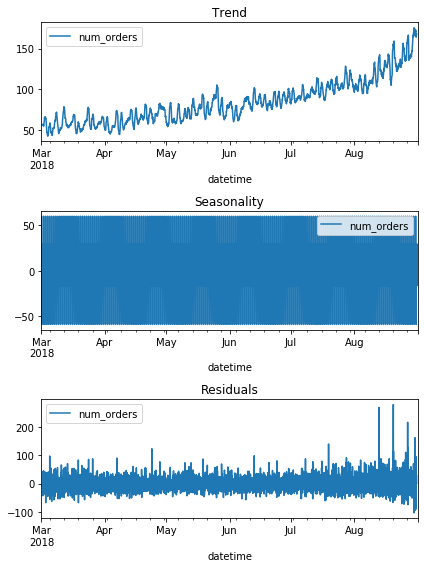

In [9]:
df = data.copy()
decomposed = seasonal_decompose(df)    
plt.figure(figsize=(6, 8))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

### По Тренду видим, что количество заказов увеличивается на всем протыжении наблюдений, для рассмотрения сезоности необходимо уменьшить период наблюдений. Возьмем данные за два дня 

Text(0.5, 1.0, 'Seasonality')

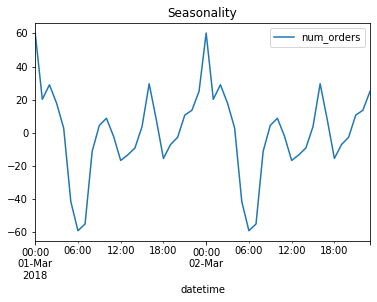

In [10]:
decomposed.seasonal['2018-03-01':'2018-03-02'].plot(ax=plt.gca())
plt.title('Seasonality')

### При уменьшении периода наблюдений можно увидить, что в течении суток количество заказов имеет значительные изменения, так наименьшее количество заказов приходится на 6.00, а максимальное на полночь 0.00. Также в течении дня видны увеличения количества заказов в 11.00 и 17.00

### Далее временной ряд опишем стохастическим процессом. Это случайная величина, у которой со временем меняется её распределение. У этой величины есть среднее и дисперсия, которые тоже меняются.

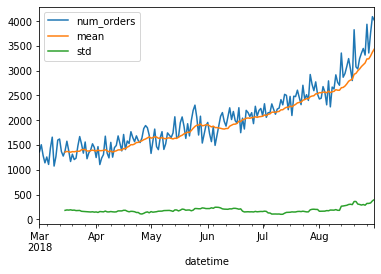

In [11]:
df = data.copy()
df = df['2018-03':'2018-08'].resample('1D').sum()
df['mean'] = df['num_orders'].rolling(15).mean()
df['std'] = df['num_orders'].rolling(15).std()
df.plot()

### На графике видно, что среднее изменяется с течение времени и следовательно нельзя признать этот временой ряд стационарным. Нестационарные ряды прогнозировать сложнее: их свойства меняются слишком быстро.

### Чтобы ряд сделать стационарным, найдём разности его значений.

In [12]:
df = data.copy()
df = df['2018-03':'2018-08'].resample('1D').sum()
df = df - df.shift()
df['rolling_mean'] = df['num_orders'].rolling(10).mean()
df['std'] = df['num_orders'].rolling(15).std()

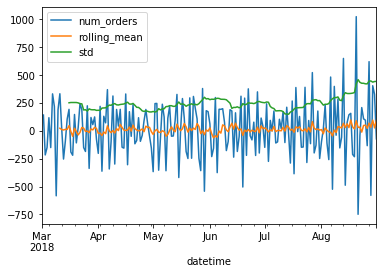

In [13]:
df.plot()

### Ряд стал более стационарным, а значит данные можно прогнозировать

# 3. Обучение

In [14]:
# сделаем времяной ряд стационареым
data = data - data.shift()

In [15]:
#  функция для создания признаков
def make_features(data, max_lag, rolling_mean_size):
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [16]:
# применим функцию к таблице, максимальный размер отставания примем равным 2
make_features(data, 2, 2)

### Добавление признака "час" сильно улучшило качество моделей. Попробывав с разными значениями отставания пришел к выводу, что для линейной регресии оптимально 1, а для леса 2. Выбор остановил на 2

In [17]:
# разделим данные на тестовую и тренировочную выборки в соотношении 80:10:10
train_valid, test = train_test_split(data, shuffle=False, test_size=0.1)
train, valid = train_test_split(train_valid, shuffle=False, test_size=0.1)
train = train.dropna()
train_valid = train_valid.dropna()

In [18]:
# выделим признаки и целевой признак
train_y = train['num_orders']
test_y = test['num_orders']
valid_y = valid['num_orders']
train_valid_y = train_valid['num_orders']

train_x = train.drop('num_orders', axis=1)
test_x = test.drop('num_orders', axis=1)
valid_x = valid.drop('num_orders', axis=1)
train_valid_x = train_valid.drop('num_orders', axis=1)

In [19]:
# обучим модель линейной регрессии
model_LR = LinearRegression()
model_LR.fit(train_x, train_y)
pred_valid_LR = model_LR.predict(valid_x)
mean_squared_error(valid_y, pred_valid_LR)**0.5

45.72089399927911

In [20]:
%%time
# обучим модель основываясь на RandomForestRegressor
i = 0
result = pd.DataFrame(columns=['max_depth', 'n_estimators', 'rMSE'])
for n_estimators in range(10, 101, 10):
     for max_depth in range(1, 10, 2): 
        model_rfr = RandomForestRegressor(max_depth=max_depth, n_estimators=n_estimators, random_state=123)
        model_rfr.fit(train_x, train_y)
        pred_valid_rfr = model_rfr.predict(valid_x)
        result.loc[i] = [max_depth, n_estimators, mean_squared_error(valid_y, pred_valid_rfr)**0.5]
        i += 1
result.sort_values('rMSE').head(5) 

CPU times: user 14.8 s, sys: 84 ms, total: 14.9 s
Wall time: 15 s


,max_depth,n_estimators,rMSE
44,9.0,90.0,35.505534
34,9.0,70.0,35.521810
49,9.0,100.0,35.534621
39,9.0,80.0,35.566253
14,9.0,30.0,35.614813


In [21]:
%%time
# обучим основываясь на библиотеке CatBoost
i = 0
result = pd.DataFrame(columns=['iteration','depth', 'learning_rate', 'rMSE'])
for iteration in range(20, 101, 10):
     for depth in range(1, 10, 2): 
        for learning_rate in np.arange(0.1, 1, 0.5):
            model = CatBoostRegressor(loss_function='RMSE', iterations=iteration , depth=depth, learning_rate=learning_rate)
            model.fit(train_x, train_y, verbose=False)
            pred_valid = model.predict(valid_x)
            result.loc[i] = [iteration, depth, learning_rate, mean_squared_error(valid_y, pred_valid)**0.5]
            i += 1
result.sort_values('rMSE').head(5)  

CPU times: user 1min 29s, sys: 13.9 s, total: 1min 43s
Wall time: 6min 12s


,iteration,depth,learning_rate,rMSE
85,100.0,5.0,0.6,33.497501
65,80.0,5.0,0.6,33.527228
75,90.0,5.0,0.6,33.566477
55,70.0,5.0,0.6,33.624842
45,60.0,5.0,0.6,33.745632


In [22]:
%%time
# Обучим модель CatBoost с параметрами  по умолчанию
model_cb = CatBoostRegressor(loss_function='RMSE')
model_cb.fit(train_x, train_y, verbose=False)
pred_valid_CB = model_cb.predict(valid_x)
mean_squared_error(valid_y, pred_valid_CB)**0.5

CPU times: user 14.2 s, sys: 2.19 s, total: 16.4 s
Wall time: 19.3 s


33.48234035105578

### Проведя обучение моделей и проверив на валидационой выборке можно отобрать для тестирования как показавшию наибольшее качество модель CatBoost со значениями по умолчанию, за тем модель случайного леса с несколько более худшим результатом и параметрами количеством деревьев равным 100 и глубиной 9. На третей позиции модель линейной регрессии. При этом все модели на валидационой выборке показали результат rMSE менее 48.

# 4. Тестирование

### Проведем тестирование на отобранных моделях. Обучим на датасете ``train+valid``

In [23]:
# обучим модель линейной регрессии
model_LR = LinearRegression()
model_LR.fit(train_valid_x, train_valid_y)
pred_test_LR = model_LR.predict(test_x)


In [24]:
# обучим модель на оптимальных гиперпараметрах
model_RFR = RandomForestRegressor(random_state=123, n_estimators=100, max_depth=9)
model_RFR.fit(train_valid_x, train_valid_y)
pred_test_RFR = model_RFR.predict(test_x)


In [25]:
%%time
# Обучим модель с параметрами  по умолчанию
model_cb = CatBoostRegressor(loss_function='RMSE')
model_cb.fit(train_valid_x, train_valid_y, verbose=False)
pred_test_CB = model_cb.predict(test_x)


CPU times: user 15.3 s, sys: 2.44 s, total: 17.7 s
Wall time: 20.4 s


In [26]:
print("rMSE тестовой выборки на линейной регрессии: ", mean_squared_error(test_y, pred_test_LR)**0.5)
print("rMSE тестовой выборки на случайном лесе: ", mean_squared_error(test_y, pred_test_RFR)**0.5)
print("rMSE тестовой выборки на CatBoost: ", mean_squared_error(test_y, pred_test_CB)**0.5)

rMSE тестовой выборки на линейной регрессии:  56.964575702875976
rMSE тестовой выборки на случайном лесе:  45.733620764193695
rMSE тестовой выборки на CatBoost:  42.47548947533569


### Наилучший результат на тестовой выборке показала модель обученная на CatBoost с результатом rMSE равным 42.47. Модель случайного леса имеет результат rMSE равным 45.73. А модель линейной регресии превысела установленое ограничение в 48 и имеет результат rMSE равным 56.96